<a href="https://colab.research.google.com/github/XingyuHu109/LLM-Pruner/blob/main/layer_experimentation_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [10]:
from huggingface_hub import login

login()

In [22]:
import torch
import re
import time
import gc
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig

plt.style.use('ggplot')

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [23]:
# Models to test
MODEL_IDS = [
    "meta-llama/Meta-Llama-3-8B",
    "facebook/layerskip-llama3-8B",
]

# Benchmark settings
DATASET_NAME = "ai2_arc"
DATASET_CONFIG = "ARC-Easy"
DATASET_SPLIT = "test"
NUM_SAMPLES = None # Use full dataset
BATCH_SIZE = 4
MAX_LENGTH = 512

USE_QUANTIZATION = False
TRUST_REMOTE_CODE = False

In [24]:
def format_prompt(example):
    """Formats an ARC example into a standardized prompt."""
    question = example['question']
    # Handle potential variations in choice labels ('A','B','C','D' vs '1','2','3','4')
    try:
        choices_dict = {str(label): text for label, text in zip(example['choices']['label'], example['choices']['text'])}
        sorted_labels = sorted(choices_dict.keys()) # Sorts '1','2','3','4' or 'A','B','C','D'
    except Exception as e:
        print(f"Error processing choices for example ID {example.get('id', 'N/A')}: {e}")
        print(f"Choices data: {example.get('choices', 'Missing')}")
        # Fallback or skip example if choices are malformed
        return None, None

    formatted_choices = "\n".join([f"{label}) {choices_dict[label]}" for label in sorted_labels])
    prompt = f"Question: {question}\nChoices:\n{formatted_choices}\nAnswer:"
    return prompt, sorted_labels

def parse_predicted_token(token_id, tokenizer, choice_labels):
    """Decodes a single token ID and checks if it's a valid choice label."""
    if token_id is None or not choice_labels:
        return None
    try:
        # Decode the single token ID, removing special tokens and stripping whitespace
        decoded_token = tokenizer.decode([token_id], skip_special_tokens=True).strip()
    except Exception as e:
        # Handle potential decoding errors with specific token IDs
        # print(f"Warning: Could not decode token ID {token_id}. Error: {e}")
        return None

    # Check if the decoded token exactly matches one of the valid choice labels
    # Compare in a case-insensitive manner if labels are alphabetic
    first_label_is_alpha = choice_labels[0].isalpha() if choice_labels else False
    for label in choice_labels:
        if first_label_is_alpha:
            if decoded_token.lower() == label.lower():
                return label # Return the canonical label from the dataset (e.g., 'A')
        else:
            if decoded_token == label:
                return label
    return None # Return None if no match found

In [25]:
def get_model_components(model):
    """Attempts to dynamically access standard components for various architectures."""
    config = model.config
    arch = config.model_type

    try:
        if arch in ["llama", "mistral"]:
            embedding_layer = model.model.embed_tokens
            transformer_blocks = model.model.layers
            final_norm = model.model.norm
            lm_head = model.lm_head
            rotatory_emb_func = getattr(model.model, 'rotary_emb', None)
        elif arch == "gpt2":
            embedding_layer = model.transformer.wte
            transformer_blocks = model.transformer.h
            final_norm = model.transformer.ln_f
            lm_head = model.lm_head
            rotatory_emb_func = None

        elif arch == "falcon":
            embedding_layer = model.transformer.word_embeddings
            transformer_blocks = model.transformer.h
            final_norm = model.transformer.ln_f
            lm_head = model.lm_head
            rotatory_emb_func = None
        else:
            print(f"Warning: Architecture '{arch}' not explicitly handled. Attempting default access.")
            # Attempt generic access (might fail)
            embedding_layer = model.get_input_embeddings()
            transformer_blocks = model.model.layers # Common but not universal
            final_norm = model.model.norm # Common but not universal
            lm_head = model.get_output_embeddings() # Often tied to lm_head
            rotatory_emb_func = None

        num_layers = len(transformer_blocks)
        print(f"Detected {num_layers} layers for architecture '{arch}'.")

        # Basic check if components were found
        if not all([embedding_layer, transformer_blocks, final_norm, lm_head]):
             raise AttributeError(f"Could not find all required components for model type '{arch}'. Check access paths.")

        return embedding_layer, transformer_blocks, final_norm, lm_head, rotatory_emb_func, num_layers

    except AttributeError as e:
        print(f"Error accessing components for model type '{arch}': {e}")
        print("Please add or adjust the component access logic in 'get_model_components' for this architecture.")
        raise


def run_early_exit_benchmark(model_id, tokenizer, model, device, dataset, batch_size, max_length):
    """Runs the layer-wise benchmark for a single loaded model."""

    print(f"\n--- Starting Benchmark for: {model_id} ---")
    results = []

    try:
        # Dynamically get components and number of layers
        embedding_layer, transformer_blocks, final_norm, lm_head, rotatory_emb_func, num_layers = get_model_components(model)
    except Exception as e:
        print(f"Could not benchmark {model_id} due to component access error: {e}")
        return None

    # The core forward pass function using accessed components
    def forward_pass_predict_token(layer_index: int, input_ids: torch.Tensor):
        hidden_state = embedding_layer(input_ids)
        batch_size, sequence_length = hidden_state.shape[0], hidden_state.shape[1]
        position_ids = torch.arange(sequence_length, device=device).unsqueeze(0).expand(batch_size, -1)

        # RoPE handling - this is model specific
        cos_sin_tuple = None
        if rotatory_emb_func and model.config.model_type in ["llama", "mistral"]:
             try:
                 # Check signature: might need seq_len, hidden_state, position_ids etc.
                 cos_sin_tuple = rotatory_emb_func(hidden_state, position_ids) # tested only on llama
             except Exception as e_rotary:
                 print(f"Warning: Rotary embedding calculation failed: {e_rotary}")


        current_hidden_state = hidden_state
        for i, layer in enumerate(transformer_blocks):
            if i > layer_index: break
            # attempt for Llama/Mistral/GPT2 like models
            # Needs refinement for specific argument requirements (attention_mask, position_ids format, RoPE passing etc.) for other models
            try:
                layer_output = layer(
                    current_hidden_state,
                    position_ids=position_ids,
                    # attention_mask=inputs['attention_mask'] # Potentially needed
                    # RoPE might be passed via position_embeddings or handled internally
                    position_embeddings=cos_sin_tuple
                )
                current_hidden_state = layer_output[0] if isinstance(layer_output, tuple) else layer_output
            except Exception as e_layer:
                print(f"Error in layer {i} forward for {model_id}: {e_layer}")
                print("Check layer signature and required arguments.")
                raise e_layer # Stop processing this layer_idx if forward fails

        normalized_embedding = final_norm(current_hidden_state)
        logits = lm_head(normalized_embedding)
        last_token_logits = logits[:, -1, :]
        result_token_ids = torch.argmax(last_token_logits, dim=-1)
        return result_token_ids

    # Iterate through each layer index for early exit evaluation
    layer_range = range(15, num_layers)
    for layer_idx in tqdm(layer_range, desc=f"Evaluating Layers ({model_id})"):
        correct_predictions = 0
        total_predictions = 0
        start_time_layer = time.time()

        with torch.no_grad():
            for i in range(0, len(dataset), batch_size):
                batch_indices = range(i, min(i + batch_size, len(dataset)))
                batch_examples = [dataset[j] for j in batch_indices]

                prompts_and_labels = [format_prompt(example) for example in batch_examples]
                # Filter out examples where formatting failed
                valid_indices = [k for k, (p, l) in enumerate(prompts_and_labels) if p is not None]
                if not valid_indices: continue # Skip batch if all examples failed formatting

                prompts = [prompts_and_labels[k][0] for k in valid_indices]
                choice_labels_batch = [prompts_and_labels[k][1] for k in valid_indices]
                actual_answer_keys = [batch_examples[k]['answerKey'] for k in valid_indices]
                current_batch_size = len(prompts)

                inputs = tokenizer(
                    prompts, return_tensors="pt", padding=True, truncation=True, max_length=max_length
                ).to(device)

                try:
                    # Get predicted token IDs using the forward pass for the current layer index
                    predicted_token_ids = forward_pass_predict_token(layer_idx, inputs['input_ids'])

                    # Decode and evaluate batch results
                    for k, token_id in enumerate(predicted_token_ids):
                        actual_answer = actual_answer_keys[k]
                        choice_labels = choice_labels_batch[k]
                        predicted_answer = parse_predicted_token(token_id.item(), tokenizer, choice_labels)

                        if predicted_answer == actual_answer:
                            correct_predictions += 1
                        total_predictions += 1

                except Exception as e_fwd:
                     # If forward pass failed for this layer, record 0 accuracy and stop for this model
                     print(f"Forward pass failed permanently at layer {layer_idx} for model {model_id}. Error: {e_fwd}")
                     # Add results with 0 accuracy for this and subsequent layers
                     for failed_layer_idx in range(layer_idx, num_layers):
                          results.append({
                             "model_id": model_id,
                             "layer_index": failed_layer_idx,
                             "num_layers": num_layers,
                             "layer_percent": (failed_layer_idx + 1) / num_layers * 100 if num_layers > 0 else 0,
                             "accuracy": 0.0,
                             "correct": 0,
                             "total": total_predictions if failed_layer_idx == layer_idx else 0, # Record total only for the failing layer
                             "time": time.time() - start_time_layer if failed_layer_idx == layer_idx else 0,
                           })
                     print(f"Stopping benchmark for {model_id} due to error.")
                     return pd.DataFrame(results) # Return partial results up to failure point




        # Calculate results for the current layer
        accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
        layer_time = time.time() - start_time_layer
        results.append({
            "model_id": model_id,
            "layer_index": layer_idx,
            "num_layers": num_layers,
            "layer_percent": (layer_idx + 1) / num_layers * 100 if num_layers > 0 else 0,
            "accuracy": accuracy,
            "correct": correct_predictions,
            "total": total_predictions,
            "time": layer_time,
        })
        # Print progress per layer
        print(f"  Layer {layer_idx+1}/{num_layers}: Acc={accuracy:.2f}% ({correct_predictions}/{total_predictions}), Time={layer_time:.2f}s")

    print(f"--- Finished Benchmark for: {model_id} ---")
    return pd.DataFrame(results)

In [26]:
# Load Dataset
print(f"Loading dataset: {DATASET_NAME} ({DATASET_CONFIG}) - Split: {DATASET_SPLIT}")
try:
    arc_dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=DATASET_SPLIT) # trust_remote_code handled per model
except Exception as e:
    print(f"Failed to load dataset: {e}")
    arc_dataset = None # Set to None to prevent proceeding

if arc_dataset and NUM_SAMPLES is not None:
    print(f"Using a subset of {NUM_SAMPLES} samples.")
    arc_dataset = arc_dataset.select(range(NUM_SAMPLES))

# Run Benchmarks for all specified models
all_model_results = {}

if arc_dataset:
    for model_id in MODEL_IDS:
        print(f"\n{'='*20} Processing Model: {model_id} {'='*20}")
        tokenizer = None
        model = None
        quantization_config = None


        try:
            print("Loading tokenizer...")
            tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=TRUST_REMOTE_CODE)
            # Ensure pad token exists for batching
            if tokenizer.pad_token is None:
                if tokenizer.eos_token:
                    tokenizer.pad_token = tokenizer.eos_token
                    print(f"Set pad_token to eos_token: {tokenizer.pad_token}")
                else:
                    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
                    print("Added pad_token: [PAD]")

            print("Loading model...")
            model = AutoModelForCausalLM.from_pretrained(
                model_id,
                device_map=device,
                torch_dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16,
                quantization_config=quantization_config,
                trust_remote_code=TRUST_REMOTE_CODE,
            )

            model.eval()

            # Run the benchmark for this model
            model_results_df = run_early_exit_benchmark(
                model_id=model_id,
                tokenizer=tokenizer,
                model=model,
                device=device,
                dataset=arc_dataset,
                batch_size=BATCH_SIZE,
                max_length=MAX_LENGTH
            )

            if model_results_df is not None:
                all_model_results[model_id] = model_results_df
                print(f"Benchmark completed for {model_id}.")
            else:
                print(f"Benchmark failed or was skipped for {model_id}.")

        except Exception as e:
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"Error processing model {model_id}: {e}")
            print(f"Skipping this model.")
            print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

        finally:
            # Memory cleanup
            print(f"Cleaning up memory for {model_id}...")
            del model
            del tokenizer
            if 'model_results_df' in locals(): del model_results_df
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            print("Cleanup complete.")

else:
    print("Dataset not loaded. Skipping benchmark runs.")

print("\nFinished processing all models.")

Loading dataset: ai2_arc (ARC-Easy) - Split: test

==================== Processing Model: meta-llama/Meta-Llama-3-8B ====================
Loading tokenizer...
Set pad_token to eos_token: <|end_of_text|>
Loading model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


--- Starting Benchmark for: meta-llama/Meta-Llama-3-8B ---
Detected 32 layers for architecture 'llama'.


Evaluating Layers (meta-llama/Meta-Llama-3-8B):   0%|          | 0/17 [00:00<?, ?it/s]

  Layer 16/32: Acc=0.00% (0/2376), Time=14.54s
  Layer 17/32: Acc=0.00% (0/2376), Time=15.14s
  Layer 18/32: Acc=0.55% (13/2376), Time=15.85s
  Layer 19/32: Acc=9.64% (229/2376), Time=16.61s
  Layer 20/32: Acc=12.16% (289/2376), Time=17.30s
  Layer 21/32: Acc=15.95% (379/2376), Time=18.10s
  Layer 22/32: Acc=17.76% (422/2376), Time=18.79s
  Layer 23/32: Acc=18.86% (448/2376), Time=19.53s
  Layer 24/32: Acc=20.66% (491/2376), Time=20.19s
  Layer 25/32: Acc=19.44% (462/2376), Time=21.01s
  Layer 26/32: Acc=21.59% (513/2376), Time=21.74s
  Layer 27/32: Acc=22.14% (526/2376), Time=22.50s
  Layer 28/32: Acc=21.76% (517/2376), Time=23.19s
  Layer 29/32: Acc=21.55% (512/2376), Time=23.94s
  Layer 30/32: Acc=22.47% (534/2376), Time=24.69s
  Layer 31/32: Acc=22.22% (528/2376), Time=25.43s
  Layer 32/32: Acc=22.10% (525/2376), Time=26.23s
--- Finished Benchmark for: meta-llama/Meta-Llama-3-8B ---
Benchmark completed for meta-llama/Meta-Llama-3-8B.
Cleaning up memory for meta-llama/Meta-Llama-3-8

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


--- Starting Benchmark for: facebook/layerskip-llama3-8B ---
Detected 32 layers for architecture 'llama'.


Evaluating Layers (facebook/layerskip-llama3-8B):   0%|          | 0/17 [00:00<?, ?it/s]

  Layer 16/32: Acc=7.28% (173/2376), Time=14.26s
  Layer 17/32: Acc=10.02% (238/2376), Time=15.01s
  Layer 18/32: Acc=18.77% (446/2376), Time=15.75s
  Layer 19/32: Acc=18.52% (440/2376), Time=16.48s
  Layer 20/32: Acc=18.48% (439/2376), Time=17.27s
  Layer 21/32: Acc=18.81% (447/2376), Time=18.00s
  Layer 22/32: Acc=19.02% (452/2376), Time=18.79s
  Layer 23/32: Acc=18.98% (451/2376), Time=19.43s
  Layer 24/32: Acc=18.77% (446/2376), Time=20.18s
  Layer 25/32: Acc=18.64% (443/2376), Time=20.90s
  Layer 26/32: Acc=19.32% (459/2376), Time=21.61s
  Layer 27/32: Acc=19.23% (457/2376), Time=22.40s
  Layer 28/32: Acc=19.36% (460/2376), Time=23.16s
  Layer 29/32: Acc=19.28% (458/2376), Time=23.78s
  Layer 30/32: Acc=19.28% (458/2376), Time=24.63s
  Layer 31/32: Acc=19.49% (463/2376), Time=25.31s
  Layer 32/32: Acc=19.44% (462/2376), Time=26.08s
--- Finished Benchmark for: facebook/layerskip-llama3-8B ---
Benchmark completed for facebook/layerskip-llama3-8B.
Cleaning up memory for facebook/laye


--- Combined Benchmark Results ---
                     model_id  layer_index  num_layers  layer_percent  \
0  meta-llama/Meta-Llama-3-8B           15          32         50.000   
1  meta-llama/Meta-Llama-3-8B           16          32         53.125   
2  meta-llama/Meta-Llama-3-8B           17          32         56.250   
3  meta-llama/Meta-Llama-3-8B           18          32         59.375   
4  meta-llama/Meta-Llama-3-8B           19          32         62.500   

    accuracy  correct  total       time  
0   0.000000        0   2376  14.541033  
1   0.000000        0   2376  15.138698  
2   0.547138       13   2376  15.845899  
3   9.638047      229   2376  16.608937  
4  12.163300      289   2376  17.295680  

--- Final Layer Accuracy ---
                        model_id  layer_index  accuracy
33  facebook/layerskip-llama3-8B           31     19.44
16    meta-llama/Meta-Llama-3-8B           31     22.10

--- Plotting Early Exit Performance ---


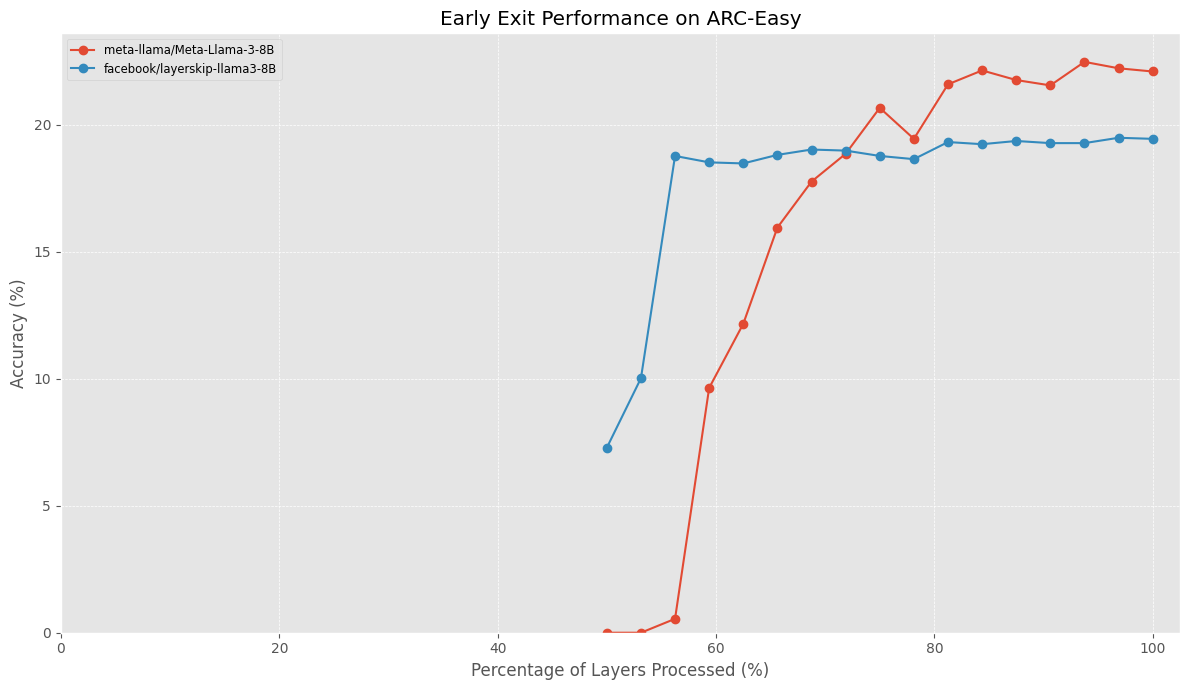

<Figure size 640x480 with 0 Axes>

In [28]:
# Results visualization
if all_model_results:
    combined_results_df = pd.concat(all_model_results.values(), ignore_index=True)

    print("\n--- Combined Benchmark Results ---")
    # Display a sample of the aggregated data
    print(combined_results_df.head())
    # Display accuracy at final layer for each model
    print("\n--- Final Layer Accuracy ---")
    final_layer_acc = combined_results_df.loc[combined_results_df.groupby('model_id')['layer_index'].idxmax()]
    print(final_layer_acc[['model_id', 'layer_index', 'accuracy']].round(2))


    # Plot results
    print("\n--- Plotting Early Exit Performance ---")
    plt.figure(figsize=(12, 7))

    model_names = combined_results_df['model_id'].unique()

    for model_name in model_names:
        model_data = combined_results_df[combined_results_df['model_id'] == model_name].sort_values('layer_percent')
        if not model_data.empty:
             plt.plot(
                 model_data['layer_percent'],
                 model_data['accuracy'],
                 marker='o',
                 linestyle='-',
                 label=model_name
             )

    plt.title(f'Early Exit Performance on {DATASET_CONFIG}')
    plt.xlabel('Percentage of Layers Processed (%)')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0) # Start y-axis at 0
    plt.xlim(left=0)   # Start x-axis at 0
    plt.tight_layout()
    plt.show()

    # Save the plot
    plt.savefig(f'early_exit_benchmark_{DATASET_CONFIG}.png', dpi=300)
    # Save combined results to CSV
    combined_results_df.to_csv(f'early_exit_benchmark_{DATASET_CONFIG}_results.csv', index=False)

else:
    print("No benchmark results")